# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [1]:
# Essentia
!pip install essentia
# Freesound-python
!pip install git+https://github.com/mtg/freesound-python.git
# Mount drive and cd to notebook folder
from google.colab import drive
drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 50.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mtg/freesound-python.git to /tmp/pip-req-build-b2id35r0
  Running command git clone --filter=blob:none --quiet https://github.com/mtg/freesound-python.git /tmp/pip-req-build-b2id35r0
  Resolved https://github.com/mtg/freesound-python.git to commit 14f2e6d35587181fb376f36fb2cfab4941c05b15
  Preparing metadata (setup.py) ... done
  Created wheel for freesound-python: filename=freesound_python-1.1-py3-none-any.whl size=6443 sha256=a064efc517bbf5af772db9d2c7101b1641b4fd197c16609563730239a03a60c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-dp8mwgzl/wheels/0e/40/c2/8769649bfe986e312e67c9fd16cfcca06fd386442f6f6ef45b
Successfully built freesound-python


MessageError: ignored

In [3]:
%cd '/content/drive/MyDrive/Term2/ASMLab/Freesound/Self work'

/content/drive/MyDrive/Term2/ASMLab/Freesound/Self work


In [4]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [5]:
features, features_frames = estd.MusicExtractor(lowlevelStats=['mean', 'stdev'],
                                              rhythmStats=['mean', 'stdev'],
                                              tonalStats=['mean', 'stdev'])('/content/drive/MyDrive/Term2/ASMLab/Freesound/Self work/files/109951_7037-hq.ogg')
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'metadata' not in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)
print(f'This subset contains {len(scalar_lowlevel_descriptors)} descriptors')



Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

In [6]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both 
# this cell and the cells below that carry out the audio analysis and that call the analysis function. 
# After analyzing the source collection or the target file, make sure to correct descriptors have been 
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table 
# using 'display(data_frame_object)'
import scipy.io.wavfile as wavfile

def analyze_sound(audio_path, frame_size=None, audio_id=None, sync_with_beats=False):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    
    # Some processing of frame_size parameter to avoid later problems
    if frame_size is None:
        frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    if frame_size % 2 != 0:
        frame_size = frame_size + 1 # Make frame size even
    
    # Calculate the start and end samples for each equally-spaced audio frame
    if sync_with_beats:
      beat_tracker_algo = estd.BeatTrackerDegara()
      beat_positions = beat_tracker_algo(audio)
      beat_positions = [int(round(position * 44100)) for position in beat_positions]
      frame_start_end_samples = zip(beat_positions[:-1], beat_positions[1:])
    else:
      frame_start_samples = range(0, len(audio), frame_size)
      frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])

    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):
        
        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame[0] = 0.1
        #print(len(frame))
        if len(frame) > 8000:

          wavfile.write('tmp.wav', 44100, frame)
          frame_output = {
              'freesound_id': audio_id,
              'id': '{0}_f{1}'.format(audio_id, count),
              'path': audio_path,
              'start_sample': fstart,
              'end_sample': fend,
          }
          
          # Extract loudness
          loudness_algo = estd.Loudness()
          loudness = loudness_algo(frame)
          frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

          # Extract MFCC coefficients
          w_algo = estd.Windowing(type = 'hann')
          spectrum_algo = estd.Spectrum()
          mfcc_algo = estd.MFCC()
          spec = spectrum_algo(w_algo(frame))
          _, mfcc_coeffs = mfcc_algo(spec)
          frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
          
          
          # Extract other features here and add to 'frame_output' dictionary
          #print('ok')
          features, features_frames = estd.MusicExtractor(lowlevelStats=['mean', 'stdev'], #MusicExtractor
                                                rhythmStats=['mean', 'stdev'],
                                                tonalStats=['mean', 'stdev'])('tmp.wav')
          #print('ok')
          selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
          #print(f'selected_features : {selected_features}')

          frame_output.update({f'{i}': features[i] for i in scalar_lowlevel_descriptors})                            
          
          # Add frame analysis results to output
          analysis_output.append(frame_output)

    return analysis_output
    

## Analyze source collection

In [66]:
# 30mn to run

DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of our analysis

# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    print(i)
    if i not in [1]:
      sound = df.iloc[i]  # Get DataFrame sound at position 'i'
      print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
      analysis_output = analyze_sound(sound['path'], frame_size=8192, audio_id=sound['freesound_id'])  # Split audio in chunks of 8192 samples (~185ms)
      analyses += analysis_output
      print(analysis_output)

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Output hidden; open in https://colab.research.google.com to view.

In [45]:
display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,648312,648312_f0,files/648312_1089955-hq.ogg,0,8192,0.007715,-779.039978,296.340881,-14.424419,-45.973839,-11.594852,-19.199547,-6.449860,-2.703621,-5.274742,1.542179,-10.556419,-16.816936,-14.418911
1,648312,648312_f1,files/648312_1089955-hq.ogg,8192,16384,0.008759,-784.712280,296.788910,-18.789219,-47.240562,-6.307537,-10.106171,-1.814758,4.422169,3.670048,1.181190,-14.086456,-20.190212,-13.178915
2,648312,648312_f2,files/648312_1089955-hq.ogg,16384,24576,0.009518,-784.414307,302.090637,-20.359989,-41.579624,-2.165962,-12.906219,-4.630169,1.924801,-0.665699,-4.264149,-18.639141,-22.018188,-16.261345
3,648312,648312_f3,files/648312_1089955-hq.ogg,24576,32768,0.009862,-785.201355,306.455811,-16.572842,-35.103733,2.271748,-19.559235,-11.645920,-0.102375,-6.905624,-5.761879,-13.567511,-21.820320,-9.849838
4,648312,648312_f4,files/648312_1089955-hq.ogg,32768,40960,0.009959,-792.909424,309.612030,-9.288589,-30.781506,2.288979,-20.119198,-20.233984,-14.165817,-6.956501,-6.474632,-16.472025,-17.821430,-10.100664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7955,435371,435371_f30,files/435371_7043405-hq.ogg,245760,253952,0.001326,-838.516785,211.137604,-109.203064,-1.578461,5.102169,-14.699051,-35.390469,-51.130547,-26.305756,-13.727180,-16.175724,-15.218678,-10.235374
7956,435371,435371_f31,files/435371_7043405-hq.ogg,253952,262144,0.001660,-774.398132,201.062607,-73.955635,15.547554,6.913277,19.070946,-16.643280,-7.866711,-5.919930,13.329453,8.319141,-4.724991,-19.586704
7957,435371,435371_f32,files/435371_7043405-hq.ogg,262144,270336,0.001784,-770.124817,169.731445,-98.990372,2.697865,-3.826225,2.303215,-15.814718,-30.115639,-7.856274,-4.751472,-27.087362,-31.169594,-35.218903
7958,435371,435371_f33,files/435371_7043405-hq.ogg,270336,278528,0.001772,-768.961792,180.033325,-78.192154,23.444908,17.828640,17.497707,-13.636171,0.429249,-3.894897,4.017597,-8.079372,-19.188160,-40.098259


,freesound_id,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
count,7960.000000,7.960000e+03,7.960000e+03,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000,7960.000000
mean,417525.942714,4.494712e+05,4.576632e+05,0.002291,-944.628296,187.929108,16.206909,5.094562,-6.529583,-5.808113,-8.635538,-4.774787,-3.986834,-2.817294,-4.348010,-3.660502,-4.015935
std,189848.080795,3.165453e+05,3.165453e+05,0.002790,159.925644,85.109550,67.409485,42.203712,30.379725,24.292017,22.753206,17.576040,15.791396,15.424478,15.923402,15.649787,12.867677
min,17019.000000,0.000000e+00,8.192000e+03,0.000000,-1264.911621,-73.164932,-200.393646,-125.619766,-127.134163,-113.288597,-134.212021,-82.455246,-64.955338,-68.568756,-72.496323,-82.375420,-70.326454
25%,249985.000000,1.802240e+05,1.884160e+05,0.000277,-1061.604218,134.995842,-27.160712,-25.719128,-25.666146,-21.039307,-19.854282,-15.747417,-14.600091,-13.249626,-14.569126,-12.226279,-10.722397
50%,434950.000000,3.932160e+05,4.014080e+05,0.001229,-944.634155,203.468933,9.585659,4.990524,-3.204388,-3.028786,-7.382761,-3.262131,-3.733654,-3.084919,-4.650373,-2.250637,-3.154463
75%,566467.000000,6.799360e+05,6.881280e+05,0.003286,-841.568817,250.676239,57.047587,32.213717,13.942552,10.483046,4.396852,5.595749,5.999084,5.980186,4.523348,5.107471,3.747189
max,678717.000000,1.310720e+06,1.318912e+06,0.022900,-523.727783,359.449280,178.791946,103.479301,78.841072,78.307739,82.452896,77.513763,76.968094,58.455730,64.495193,66.848900,54.910084


## Analyze the target sound file

Analyzing target sound /content/drive/MyDrive/Term2/ASMLab/Freesound/Self work/80BPMshort-vynehall-midnight.mp3
Saved target dataframe with 1297 entries! dataframe_target.csv


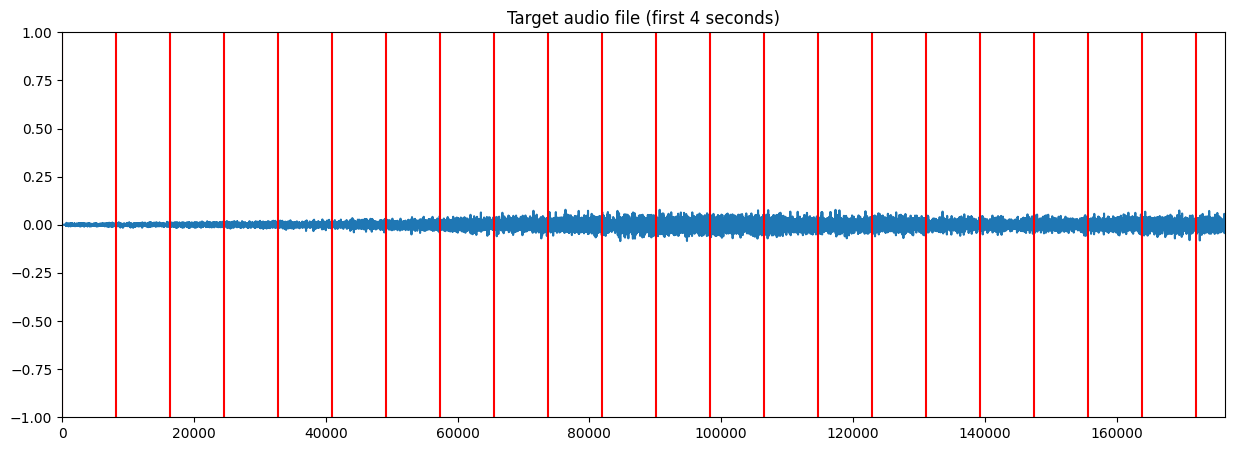

,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,tonal.hpcp_crest.stdev,tonal.hpcp_entropy.mean,tonal.hpcp_entropy.stdev,tonal.key_edma.strength,tonal.key_krumhansl.strength,tonal.key_temperley.strength,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio
0,None,None_f0,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,0,8192,0.000026,-1038.949097,121.769440,19.057259,-14.327213,...,5.268116,3.334442,0.823821,0.565516,0.558661,0.567764,0.343569,0.285059,446.142181,0.936852
1,None,None_f1,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,8192,16384,0.000038,-1015.471741,130.681381,16.440369,-12.663589,...,1.919071,2.820398,0.377840,0.582214,0.588548,0.599750,0.489039,0.355163,431.193909,0.984074
2,None,None_f2,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,16384,24576,0.000056,-993.069702,140.228012,12.785439,-7.077526,...,7.819805,2.420071,0.707431,0.390470,0.391042,0.390292,0.299162,0.228401,435.952271,0.847209
3,None,None_f3,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,24576,32768,0.000067,-981.654480,142.843994,6.431339,-9.287704,...,2.060966,2.982857,0.249282,0.493009,0.487285,0.493364,0.294373,0.188438,438.477722,0.836995
4,None,None_f4,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,32768,40960,0.000090,-955.219604,142.877655,3.969700,-3.962158,...,4.316316,3.040652,0.811050,0.485900,0.489229,0.490571,0.442452,0.240705,433.191071,0.875531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,None,None_f1292,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,10584064,10592256,0.007857,-674.340515,251.253113,-24.584583,-5.149708,...,1.908317,1.646257,0.097808,0.756338,0.763523,0.759308,0.648340,0.064854,437.465790,0.681195
1293,None,None_f1293,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,10592256,10600448,0.007713,-606.879883,167.542969,7.709484,13.687643,...,2.113155,2.327412,0.379128,0.717349,0.715138,0.708234,0.472621,0.107477,442.037933,0.760519
1294,None,None_f1294,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,10600448,10608640,0.007308,-659.025757,215.742065,-16.843132,-0.026451,...,1.815482,2.021533,0.338787,0.729999,0.734324,0.739203,0.571356,0.057693,439.491974,0.677608
1295,None,None_f1295,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,10608640,10616832,0.008750,-653.495056,213.339508,-18.737274,-16.807209,...,4.486928,1.806028,0.600501,0.733831,0.726568,0.712390,0.611574,0.114577,444.598633,0.683127


,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,tonal.hpcp_crest.stdev,tonal.hpcp_entropy.mean,tonal.hpcp_entropy.stdev,tonal.key_edma.strength,tonal.key_krumhansl.strength,tonal.key_temperley.strength,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio
count,1.297000e+03,1.297000e+03,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,...,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,5.308416e+06,5.316608e+06,0.007685,-710.127136,223.985611,-6.443573,7.967007,-1.297881,14.343380,5.019581,...,3.883195,1.967245,0.439693,0.637396,0.635719,0.630633,0.531113,0.150278,439.908845,0.777704
std,3.068362e+06,3.068362e+06,0.003496,64.772057,34.059650,20.739611,17.955009,11.913980,11.067398,9.872661,...,2.307254,0.496034,0.191321,0.094163,0.094899,0.095476,0.090947,0.076826,4.528157,0.104949
min,0.000000e+00,8.192000e+03,0.000026,-1038.949097,107.429939,-80.105820,-28.203442,-45.601967,-19.436775,-31.285450,...,0.087358,0.086468,0.010777,0.286031,0.290175,0.295401,0.227950,0.000181,431.193909,0.565688
25%,2.654208e+06,2.662400e+06,0.004745,-747.997314,207.871460,-21.538383,-6.120667,-7.706715,7.888157,-1.635975,...,2.296317,1.646634,0.304085,0.582599,0.582172,0.569131,0.471367,0.094842,437.213165,0.689927
50%,5.308416e+06,5.316608e+06,0.008990,-700.906067,230.909790,-8.182285,5.420475,0.962326,15.204641,5.111034,...,3.310139,1.940243,0.420847,0.640592,0.635058,0.631977,0.546782,0.139077,438.984558,0.764559
75%,7.962624e+06,7.970816e+06,0.010456,-668.692383,249.527130,7.145252,20.874702,7.008339,22.228710,12.292694,...,4.673853,2.261371,0.550265,0.704475,0.702571,0.700362,0.600448,0.196396,441.782684,0.859598
max,1.061683e+07,1.062502e+07,0.012773,-543.624878,292.325928,53.012299,64.106491,26.185631,45.460510,32.175224,...,12.560743,3.629566,1.237528,0.881764,0.882003,0.859410,0.728317,0.426701,456.570251,0.996029


In [70]:
# 
TARGET_SOUND_PATH = '/content/drive/MyDrive/Term2/ASMLab/Freesound/Self work/80BPMshort-vynehall-midnight.mp3'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
target_analysis = analyze_sound(TARGET_SOUND_PATH, frame_size=8192)  # Also split audio in chunks of 8192 samples (~185ms)
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

Analyzing target sound /content/drive/MyDrive/Term2/ASMLab/Freesound/Self work/160BPM-SidewinderFloat.mp3
Saved target dataframe with 1133 entries! dataframe_target2.csv


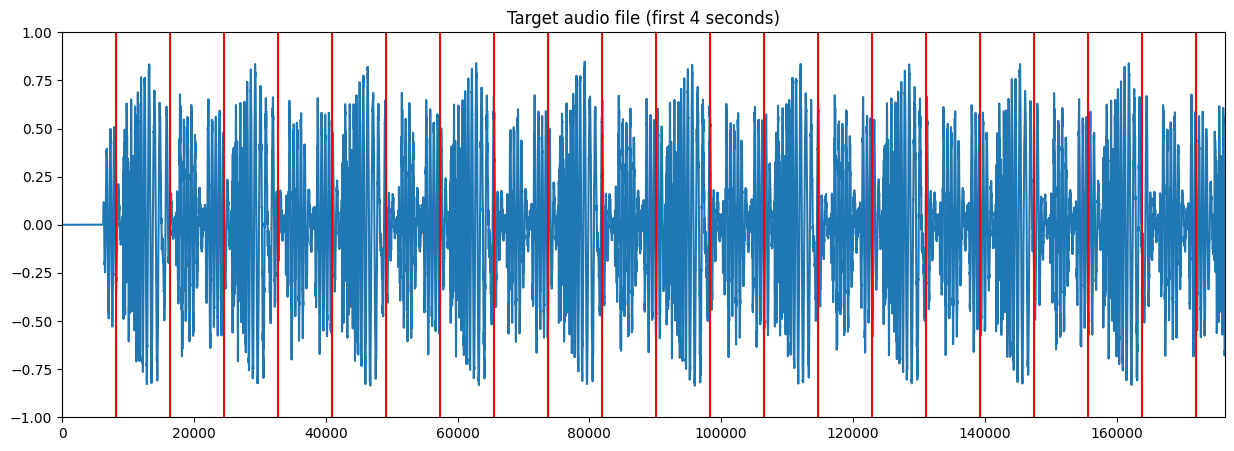

,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,tonal.hpcp_crest.stdev,tonal.hpcp_entropy.mean,tonal.hpcp_entropy.stdev,tonal.key_edma.strength,tonal.key_krumhansl.strength,tonal.key_temperley.strength,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio
0,None,None_f0,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,0,8192,0.003821,-1096.191895,174.505981,91.562256,74.509247,...,6.617502,2.029006,1.111045,0.608216,0.603238,0.592105,0.271603,0.140779,442.804626,0.727641
1,None,None_f1,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,8192,16384,0.015462,-762.171265,200.489090,33.221355,82.598190,...,2.981006,2.285900,0.667151,0.657696,0.661302,0.659685,0.513285,0.236693,441.782684,0.888435
2,None,None_f2,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,16384,24576,0.010687,-847.348755,196.562897,28.698566,75.332687,...,3.560408,1.371387,0.488749,0.570598,0.555770,0.573892,0.390624,0.132409,435.197479,0.735289
3,None,None_f3,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,24576,32768,0.014759,-747.097046,193.473907,30.439861,80.168060,...,1.044896,1.147403,0.151187,0.569590,0.576816,0.583717,0.630265,0.201219,445.112549,0.862661
4,None,None_f4,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,32768,40960,0.010438,-867.691772,193.153748,38.643517,91.540085,...,2.940929,1.543819,0.323535,0.625756,0.609552,0.581677,0.373130,0.209835,432.940918,0.798478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,None,None_f1128,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,9240576,9248768,0.006469,-552.940002,74.768723,26.940031,11.592520,...,4.723570,2.466581,0.825440,0.584943,0.600771,0.619080,0.344759,0.271550,433.691803,0.936180
1129,None,None_f1129,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,9248768,9256960,0.008311,-543.686584,105.643280,4.994923,13.327066,...,2.070125,2.210973,0.378673,0.465782,0.462527,0.463065,0.471750,0.268905,455.779724,0.967890
1130,None,None_f1130,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,9256960,9265152,0.006216,-562.849670,76.281151,30.796917,11.285236,...,3.289887,2.529723,0.723241,0.439509,0.446169,0.482075,0.325372,0.132409,441.527557,0.748631
1131,None,None_f1131,/content/drive/MyDrive/Term2/ASMLab/Freesound/...,9265152,9273344,0.009085,-564.957947,118.842712,12.502928,14.742939,...,4.286555,2.432610,0.590997,0.547479,0.546409,0.542519,0.454815,0.173964,443.060425,0.874023


,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,tonal.hpcp_crest.stdev,tonal.hpcp_entropy.mean,tonal.hpcp_entropy.stdev,tonal.key_edma.strength,tonal.key_krumhansl.strength,tonal.key_temperley.strength,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio
count,1.133000e+03,1.133000e+03,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,...,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000
mean,4.636672e+06,4.644864e+06,0.011667,-648.014648,106.784081,54.507881,39.170918,4.417026,4.859741,-6.241725,...,3.985413,1.767819,0.519214,0.505669,0.503957,0.500526,0.408191,0.226993,440.738109,0.875063
std,2.680531e+06,2.680531e+06,0.003300,90.064308,50.141869,35.620365,20.730267,15.668311,10.999871,9.623246,...,2.022018,0.344585,0.190080,0.120657,0.119211,0.114873,0.085892,0.048471,7.273524,0.062331
min,0.000000e+00,8.192000e+03,0.001047,-1096.191895,16.530779,-29.734089,-22.881813,-42.398602,-27.638901,-51.048756,...,0.155222,0.825263,0.054070,0.230482,0.236323,0.224242,0.183305,0.069157,431.193909,0.634673
25%,2.318336e+06,2.326528e+06,0.010110,-681.836365,72.136765,27.600210,25.031235,-5.615118,-2.992500,-11.954151,...,2.677933,1.511613,0.380034,0.414768,0.414864,0.416827,0.350515,0.194686,435.197479,0.832973
50%,4.636672e+06,4.644864e+06,0.011274,-623.653015,99.386353,49.102135,36.331551,7.052315,5.976557,-6.289751,...,3.528728,1.727412,0.509550,0.496174,0.497630,0.491665,0.403484,0.227763,437.971466,0.883885
75%,6.955008e+06,6.963200e+06,0.014825,-586.505188,121.797462,79.520393,50.892006,16.173349,12.986761,0.478010,...,4.444893,1.958879,0.646795,0.593080,0.589136,0.580465,0.461622,0.258445,446.142181,0.924972
max,9.273344e+06,9.281536e+06,0.018154,-504.302277,264.148010,145.553177,92.223038,47.666550,37.701340,21.742224,...,10.572764,3.086859,1.112623,0.872151,0.868533,0.835950,0.722164,0.360026,456.570251,0.984209


In [7]:
# 
TARGET_SOUND_PATH = '/content/drive/MyDrive/Term2/ASMLab/Freesound/Self work/160BPM-SidewinderFloat.mp3'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target2.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
target_analysis = analyze_sound(TARGET_SOUND_PATH, frame_size=8192)  # Also split audio in chunks of 8192 samples (~185ms)
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame